In [1]:
import numpy as np  
import matplotlib.pyplot as plt
import pandas as pd
from collections import defaultdict
% matplotlib inline

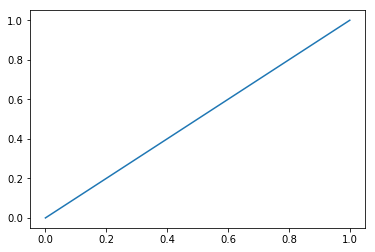

In [2]:
plt.plot([0,1], [0,1]) # hack to get startet matplotlib ... I know...

### Utility functions ###

Initialize graph with parameters for Q and S (D=Q+S)

In [3]:
def init_graph(L, N):
    mu_Q = (np.random.rand(N*L))*np.ones(L).repeat(N)
    mu_Q = mu_Q.reshape((L,N))
    mu_S = (np.random.rand(N*L))*np.ones(L).repeat(N)
    mu_S = mu_S.reshape((L,N))
    var_Q = (np.random.rand(N*L))*np.ones(L).repeat(N)
    var_Q = var_Q.reshape((L,N))
    var_S = (np.random.rand(N*L))*np.ones(L).repeat(N)
    var_S = var_S.reshape((L,N))
    
    return {"mu_Q":mu_Q, "mu_S":mu_S, "var_Q": var_Q, "var_S": var_S}

Given a LxN graph, pick a pair of paths that differ only by ith node fo layer *layer*

In [4]:
def path_pair(layer, i, j, L, N):
    path_i = np.random.choice(N, L)
    path_j = path_i.copy()
    path_i[layer] = i
    path_j[layer] = j
    
    return path_i, path_j

Draw P random delays for each node according to their distributions

In [5]:
def draw_delays(mu, var, P, distr):
    L = mu.shape[0]
    N = mu.shape[1]
    draw = []
    
    if distr == "exp":
        R = np.random.exponential(mu, size=(P,L,N))
    if distr == "gaussian":
        R = np.add(mu, np.multiply(np.power(var, 0.5), np.random.randn(P,L,N)))
    return np.abs(R)

Approximate the deviations for all the nodes of a layer

In [6]:
def approximate_diffs(layer, graph, distr, P):
    L = graph["mu_Q"].shape[0]
    N = graph["mu_Q"].shape[1]
    coefs = np.arange(1,N+1)[::-1]
            
    delays_Q = draw_delays(graph["mu_Q"], graph["var_Q"], P, distr["Q"])
    delays_S = draw_delays(graph["mu_S"], graph["var_S"], P, distr["S"])
    D = delays_Q + delays_S

    travel_times = []
    
    # we do not bother implement the log(N) comparison scheme, and compare everybody to everybody instead
    mu_diffs = np.zeros((N,N))
    var_diffs = np.zeros((N,N))
    for i in range(N-1):
        for j in range(i+1, N):
            path_i, path_j = path_pair(layer, i, j, L, N)
            travel_times_i = D[:, np.arange(L), path_i].sum(axis=1)
            travel_times_j = D[:, np.arange(L), path_j].sum(axis=1)
            
            mu_delay_i = travel_times_i.mean()
            mu_delay_j = travel_times_j.mean()
            
            mu_diffs[i,j] = mu_delay_i-mu_delay_j
            mu_diffs[j,i] = mu_delay_j-mu_delay_i
        
            var_delay_i = travel_times_i.var()
            var_delay_j = travel_times_j.var()
            
            var_diffs[i,j] = var_delay_i-var_delay_j
            var_diffs[j,i] = var_delay_j-var_delay_i

            travel_times += list(travel_times_i)
            travel_times += list(travel_times_j)

            
            
    return mu_diffs, var_diffs, travel_times

Returns the true and approximated differences of all the nodes within a given layer

In [7]:
def plot_graph(data, sla):
    L, N = data.shape[1], data.shape[2]
    plt.rcParams.update(plt.rcParamsDefault)    
    f, ax = plt.subplots(L, N, figsize=(20,12))
    
    max_X, max_Y = 0,0
    for l in range(L):
        for n in range(N):
            hist, bins = np.histogram(data[:,l,n], bins=100, density=0)
            center = (bins[:-1] + bins[1:]) / 2
            normalized = hist/np.sum(hist)
            ax[l][n].plot(center, normalized, label="(" + str(l)+","+str(n) + ")")
            max_X = max(max_X, center.max())
            max_Y = max(max_Y, normalized.max())
            t = np.mean(data[:,l,:]) + sla[l]
            max_X = max(max_X, t)


    for l in range(L):
        for n in range(N):
            mu = np.mean(data[:,l,n])
            ax[l][n].plot([mu, mu], [0, max_Y], "black", label="$\mu$")
            ax[l][n].set_xticks(np.around(np.arange(0, max_X, 0.25*max_X)))
            ax[l][n].set_yticks(np.arange(0, max_Y, np.around(0.25*max_Y, decimals=2)))
            ax[l][n].set_ylim((0, max_Y))
            ax[l][n].set_xlim((0, max_X))
            t = np.mean(data[:,l,:]) + sla[l] 
            ax[l][n].plot([t, t], [0, max_Y], "r--", label="sla")
            ax[l][n].legend()
            


## Performance Monitoring: Random walk [mu_S] ###

Generate a graph with random distribution means

In [27]:
N = 4
L = 4
distr ={"Q":"exp", "S":"exp"}

graph = init_graph(L, N)
graph["mu_Q"][:] =0

for layer in range(L):
    graph["mu_S"][layer]+=(layer+1)*15
    
graph["var_Q"][:] =0
graph["var_S"][:] =1

sla = {"mu_Q"  : np.zeros(L),
       "var_Q" : np.zeros(L),
       "mu_S"  : np.zeros(L),
       "var_S" : np.zeros(L),
    }

sla_treshold = 0.5 # 50% of layer mean

for l in range(L):
    sla["mu_Q"][l] = np.mean(graph["mu_Q"][l])*sla_treshold
    sla["var_Q"][l] = np.mean(graph["var_Q"][l])*sla_treshold
    sla["mu_S"][l] = np.mean(graph["mu_S"][l])*sla_treshold
    sla["var_S"][l] = np.mean(graph["var_S"][l])*sla_treshold
    

    
graph["mu_S"], sla

(array([[ 15.50895762,  15.58408653,  15.8080143 ,  15.38157801],
        [ 30.31021844,  30.63343414,  30.09631907,  30.53002408],
        [ 45.93707977,  45.28997022,  45.69113427,  45.07958002],
        [ 60.37230345,  60.44937947,  60.70025718,  60.35858989]]),
 {'mu_Q': array([ 0.,  0.,  0.,  0.]),
  'mu_S': array([  7.78532956,  15.19624947,  22.74972054,  30.23506625]),
  'var_Q': array([ 0.,  0.,  0.,  0.]),
  'var_S': array([ 0.5,  0.5,  0.5,  0.5])})

## Queue time distribution

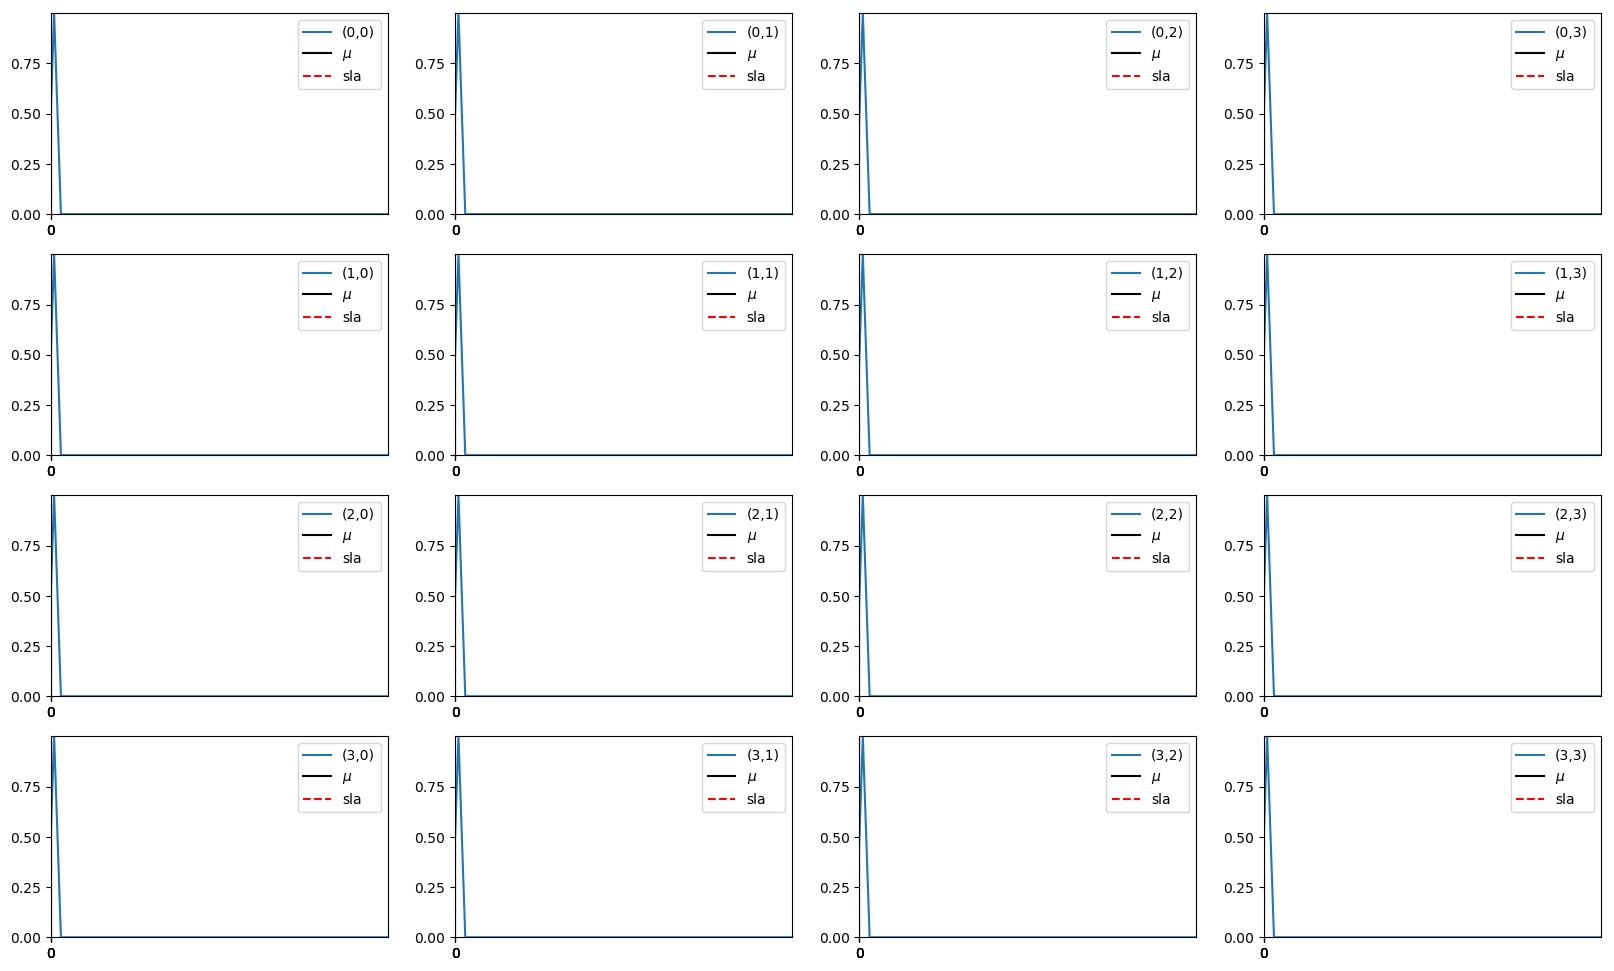

In [9]:
data_q = draw_delays(graph["mu_Q"], graph["var_Q"], P=10000, distr=distr["Q"])
plot_graph(data_q, sla=sla["mu_Q"])

## Service time distribution


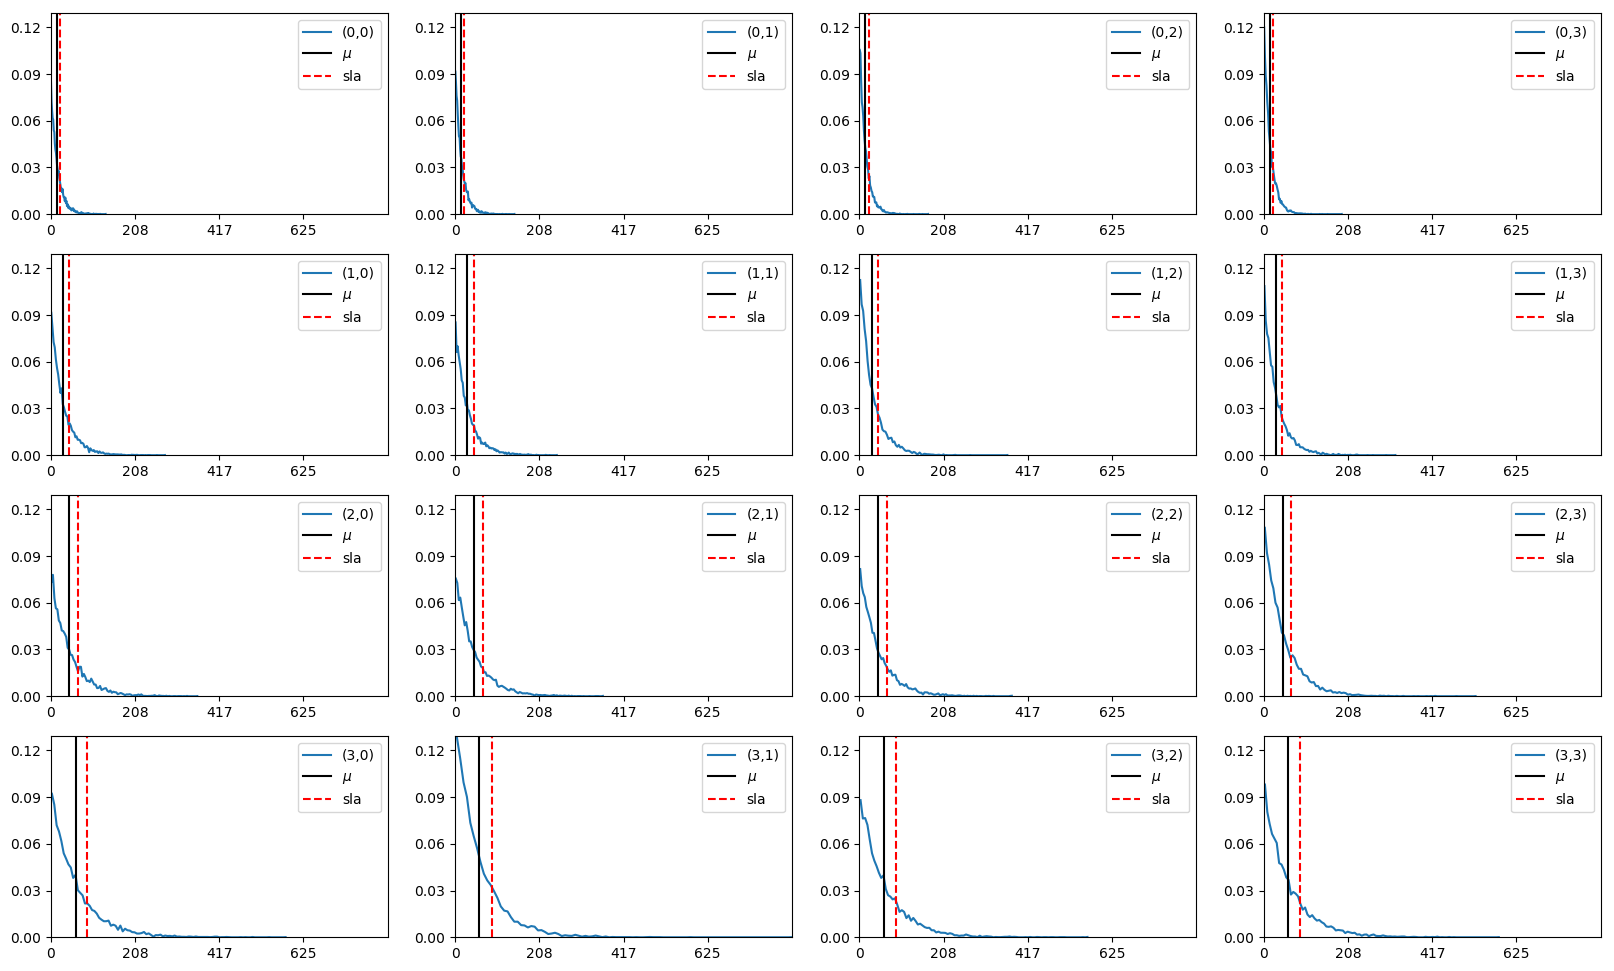

In [10]:
data_s = draw_delays(graph["mu_S"], graph["var_S"], P=10000, distr=distr["S"])
plot_graph(data_s, sla=sla["mu_S"])

## Delays distribution (Delay = Queue + Service)


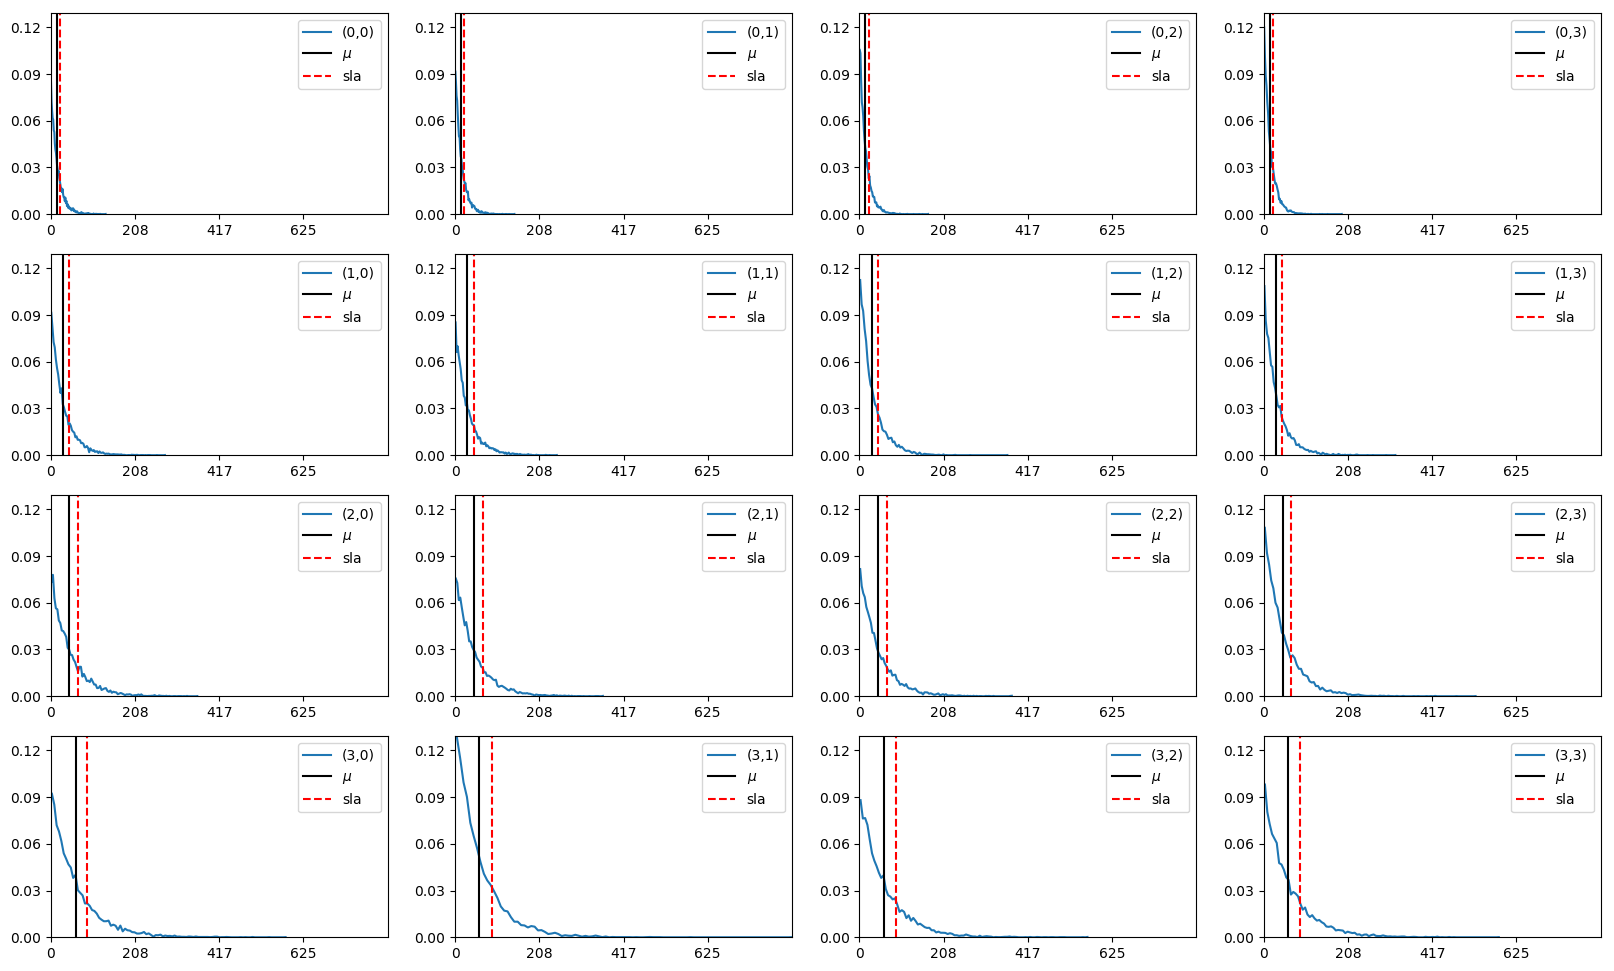

In [11]:
plot_graph(data_q+data_s, sla=sla["mu_S"])

Random walk during 700 timesteps, altering mu_S by a random number

In [28]:
steps = 701
win_size = 1
diff_mu_approx = np.zeros((steps, L, N)) 
mu = np.zeros((steps, L, N))

percentiles = np.zeros((steps, 5))

orig = graph["mu_S"].copy()
print(orig)
P=1500
resets = defaultdict(list)

for s in range(steps):
    mu[s] = graph["mu_S"] + graph["mu_Q"] 
    travel_times = []
    for layer in range(L):
        diffs, diffs_var, trav_times = approximate_diffs(layer, graph, distr, P)
        travel_times += trav_times        
        minimum = np.argsort(diffs.sum(axis=1))[0]
        diff_mu_approx[s][layer] = -diffs[minimum]
        
        for node in range(N):
    
            roll = pd.Series(diff_mu_approx[:s+1,layer,node]).rolling(win_size, min_periods=1).mean()
            if roll.values[-1] > sla["mu_S"][layer]:
                resets[layer].append((s, diff_mu_approx[s,layer,node]))
                print(s,"/", steps, "reset", layer, node, ":", graph["mu_S"][layer][node] , "to", orig[layer][node])
                graph["mu_S"][layer][node] = orig[layer][node]
    
            # random walk
            graph["mu_S"][layer][node] += 2*(layer+1)*(np.random.rand()-0.5)
            graph["mu_S"][layer][node] = max(graph["mu_S"][layer][node], orig[layer][node])
            
            if s > 600: # regime change --> traffic increases
                graph["mu_Q"][layer][node] += (layer+1)*(np.random.rand()-0.4)
                graph["mu_Q"][layer][node] = np.abs(graph["mu_Q"][layer][node])

                
            if s > 350 and s < 450: # one node gets more traffic than the rest
                if layer == 2 and node == 2:
                    graph["mu_Q"][layer][node] += (layer+1)*(np.random.rand()-0.2)
                    graph["mu_Q"][layer][node] = np.abs(graph["mu_Q"][layer][node])

            if s > 450 and s < 600: # node 2,2 gets back to normal
                if layer == 2 and node == 2:
                    graph["mu_Q"][layer][node] = 0
            

            len_tt = len(travel_times)
            
            
            
            #    graph["mu_Q"][layer][node] += (layer+1)*(np.random.rand()-0.3)
            #    graph["mu_Q"][layer][node] = max(graph["mu_Q"][layer][node], orig[layer][node])
                
            
    perc_idx = [x for x in range(int(len_tt/5), len_tt+1, int(len_tt/5))]
    perc_idx[-1] = perc_idx[-1]-1
    percentiles[s] = np.array(sorted(travel_times))[perc_idx]
    
graph["mu_S"]

[[ 15.50895762  15.58408653  15.8080143   15.38157801]
 [ 30.31021844  30.63343414  30.09631907  30.53002408]
 [ 45.93707977  45.28997022  45.69113427  45.07958002]
 [ 60.37230345  60.44937947  60.70025718  60.35858989]]
41 / 701 reset 2 3 : 65.9109621082 to 45.0795800184
60 / 701 reset 1 1 : 44.5970960192 to 30.6334341357
70 / 701 reset 0 1 : 23.0516423213 to 15.5840865323
80 / 701 reset 1 3 : 47.2086422248 to 30.5300240824
83 / 701 reset 0 0 : 22.3924971921 to 15.5089576217
99 / 701 reset 1 0 : 45.593712359 to 30.3102184442
104 / 701 reset 0 0 : 23.046358028 to 15.5089576217
108 / 701 reset 1 1 : 45.9134278178 to 30.6334341357
111 / 701 reset 2 3 : 66.1048019319 to 45.0795800184
131 / 701 reset 1 2 : 46.1487455761 to 30.0963190685
145 / 701 reset 3 1 : 89.8755892089 to 60.4493794682
179 / 701 reset 1 3 : 43.4758379204 to 30.5300240824
185 / 701 reset 3 3 : 87.812445828 to 60.3585898863
186 / 701 reset 0 3 : 23.950037358 to 15.3815780121
225 / 701 reset 1 2 : 46.0467580549 to 30.09631

683 / 701 reset 1 2 : 30.4134731851 to 30.0963190685
684 / 701 reset 1 2 : 31.4872216229 to 30.0963190685
685 / 701 reset 1 2 : 30.0963190685 to 30.0963190685
686 / 701 reset 1 2 : 30.0963190685 to 30.0963190685
687 / 701 reset 1 2 : 30.9516268515 to 30.0963190685
687 / 701 reset 3 1 : 69.6956893712 to 60.4493794682
687 / 701 reset 3 3 : 80.4546686652 to 60.3585898863
689 / 701 reset 1 2 : 30.0963190685 to 30.0963190685
690 / 701 reset 1 2 : 30.7237577244 to 30.0963190685
690 / 701 reset 3 0 : 83.5398693061 to 60.3723034532
691 / 701 reset 1 2 : 31.2352153371 to 30.0963190685
692 / 701 reset 1 2 : 30.619418749 to 30.0963190685
692 / 701 reset 3 1 : 67.3429522907 to 60.4493794682
693 / 701 reset 1 2 : 31.4286982929 to 30.0963190685
693 / 701 reset 3 1 : 64.0846336165 to 60.4493794682
694 / 701 reset 1 2 : 30.6333388063 to 30.0963190685
694 / 701 reset 2 0 : 57.6049192179 to 45.937079772
695 / 701 reset 1 2 : 30.0963190685 to 30.0963190685
695 / 701 reset 3 1 : 60.4493794682 to 60.449379

array([[ 17.0871505 ,  17.6124808 ,  21.00067116,  19.01401823],
       [ 38.86473766,  30.63343414,  30.09631907,  30.53002408],
       [ 49.98653974,  45.28997022,  49.84958319,  57.98107662],
       [ 61.67683682,  64.60730936,  61.80258669,  61.49613275]])

Plot the results

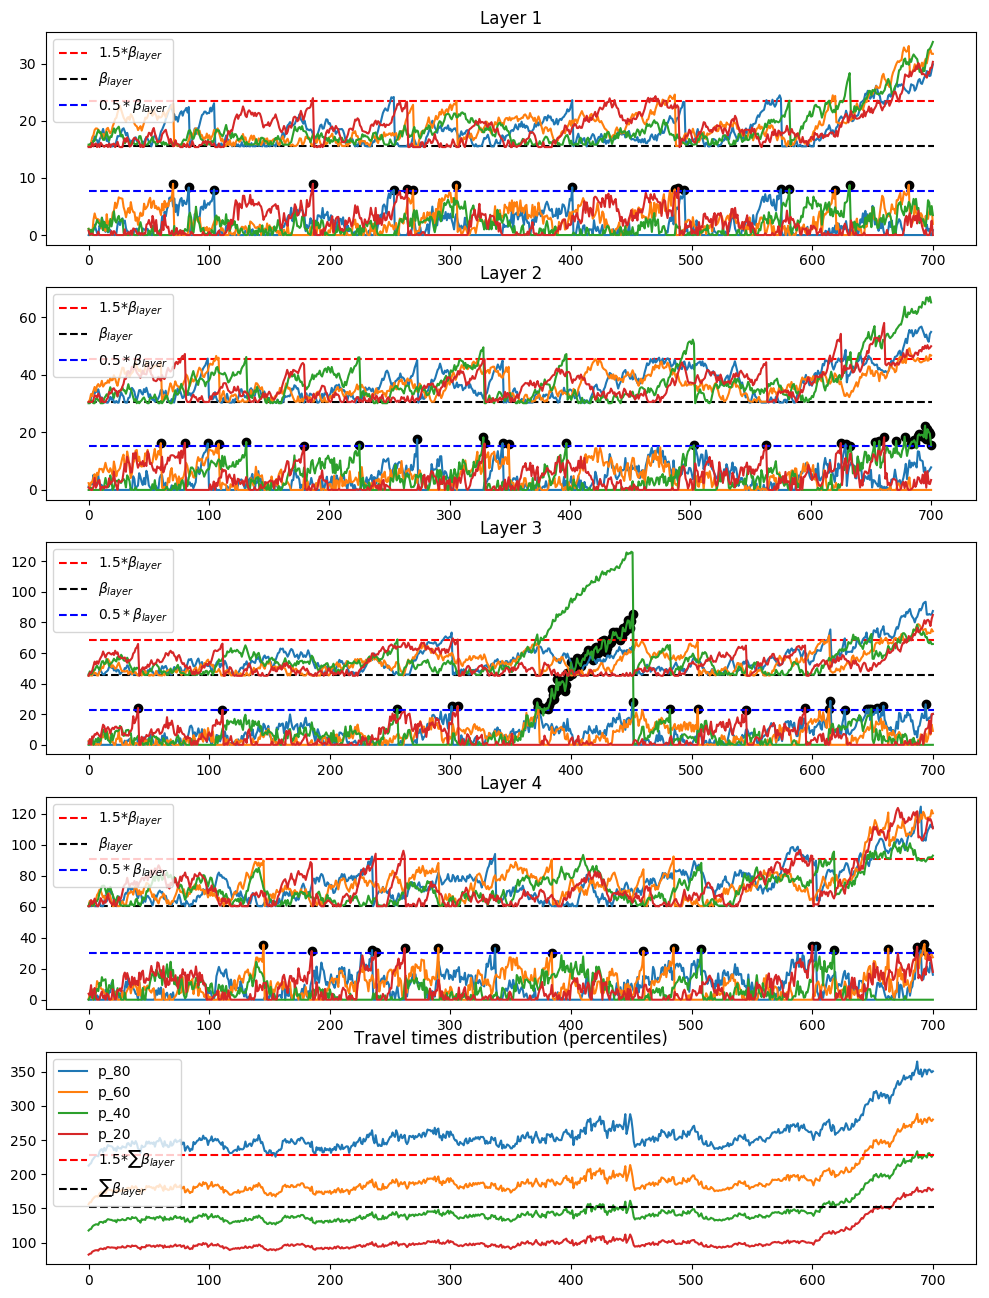

In [55]:
plt.rcParams.update(plt.rcParamsDefault)    
f, ax = plt.subplots(L+1, figsize=(12,16))

colors = ['C0', 'C1', 'C2', 'C3', 'C4', 'C5', 'C6', 'C7', 'C8', 'C9']

for layer in range(L):

    
    
    t = np.mean(orig[layer]) + sla["mu_S"][layer] 
    ax[layer].plot([0, len(diff_mu_approx)], [t, t], "r--", label=r'1.5*$\beta_{layer}$')
    t = np.mean(orig[layer]) 
    ax[layer].plot([0, len(diff_mu_approx)], [t, t], "--", c="black", label=r"$\beta_{layer}$")

    ax[layer].plot([0, len(diff_mu_approx)], [sla["mu_S"][layer], sla["mu_S"][layer]], "b--", label=r"$0.5*\beta_{layer}$")

    ax[layer].scatter([x[0] for x in resets[layer]], [x[1] for x in resets[layer]], c="black", marker='o')
    
    for n in range(N):
        ax[layer].plot(diff_mu_approx[:,layer,n], color=colors[n])
        ax[layer].plot(mu[:,layer, n], color=colors[n])
    ax[layer].legend(loc="upper left")
    ax[layer].set_title("Layer " + str(layer+1))


for i in range(4,0,-1):
    label = "p_"+str((i)*20)
    ax[L].plot(percentiles[:,i-1], label=label)
    ax[L].set_title("Travel times distribution (percentiles)")

t = np.mean(orig, axis=1).sum() + np.sum(sla["mu_S"])
ax[L].plot([0, len(diff_mu_approx)], [t, t], "--", c="red", label=r"1.5*$\sum\beta_{layer}$")

t = np.mean(orig, axis=1).sum()
ax[L].plot([0, len(diff_mu_approx)], [t, t], "--", c="black", label=r"$\sum\beta_{layer}$")

ax[L].legend(loc="upper left")


## Performance Monitoring: Random Walk [sig_S] ###

In [14]:
N = 4
L = 4
distr ={"Q":"exp", "S":"gaussian"}

graph = init_graph(L, N)
graph["mu_Q"][:] +=5

for layer in range(L):
    graph["mu_S"][layer]+=(layer+1)*15

for layer in range(L):
    #graph["var_S"][layer]=1
    graph["var_S"][layer]+=(layer+1)*15


    
graph["var_Q"][:] = 0

sla = {"mu_Q"  : np.zeros(L),
       "var_Q" : np.zeros(L),
       "mu_S"  : np.zeros(L),
       "var_S" : np.zeros(L),
    }

sla_treshold = 0.5

for l in range(L):
    sla["mu_Q"][l] = np.mean(graph["mu_Q"][l])*sla_treshold
    sla["var_Q"][l] = np.mean(graph["var_Q"][l])*sla_treshold
    sla["mu_S"][l] = np.mean(graph["mu_S"][l])*sla_treshold
    sla["var_S"][l] = np.mean(graph["var_S"][l])*1
    
graph["mu_S"], graph["var_S"], sla

(array([[ 15.34599045,  15.47863297,  15.72862727,  15.50537358],
        [ 30.04401632,  30.14418564,  30.73958711,  30.6246463 ],
        [ 45.62382181,  45.10867472,  45.01256482,  45.15185914],
        [ 60.71195658,  60.38956673,  60.73018767,  60.19103077]]),
 array([[ 15.22605009,  15.58238505,  15.32035258,  15.54628284],
        [ 30.72708326,  30.96488676,  30.7830583 ,  30.45011963],
        [ 45.44522759,  45.99950764,  45.03530487,  45.51498664],
        [ 60.1546019 ,  60.64145201,  60.37371142,  60.74381902]]),
 {'mu_Q': array([ 2.79141306,  2.74544772,  2.7536534 ,  2.72706335]),
  'mu_S': array([  7.75732803,  15.19405442,  22.61211506,  30.25284272]),
  'var_Q': array([ 0.,  0.,  0.,  0.]),
  'var_S': array([ 15.41876764,  30.73128699,  45.49875668,  60.47839609])})

## Queue time distribution

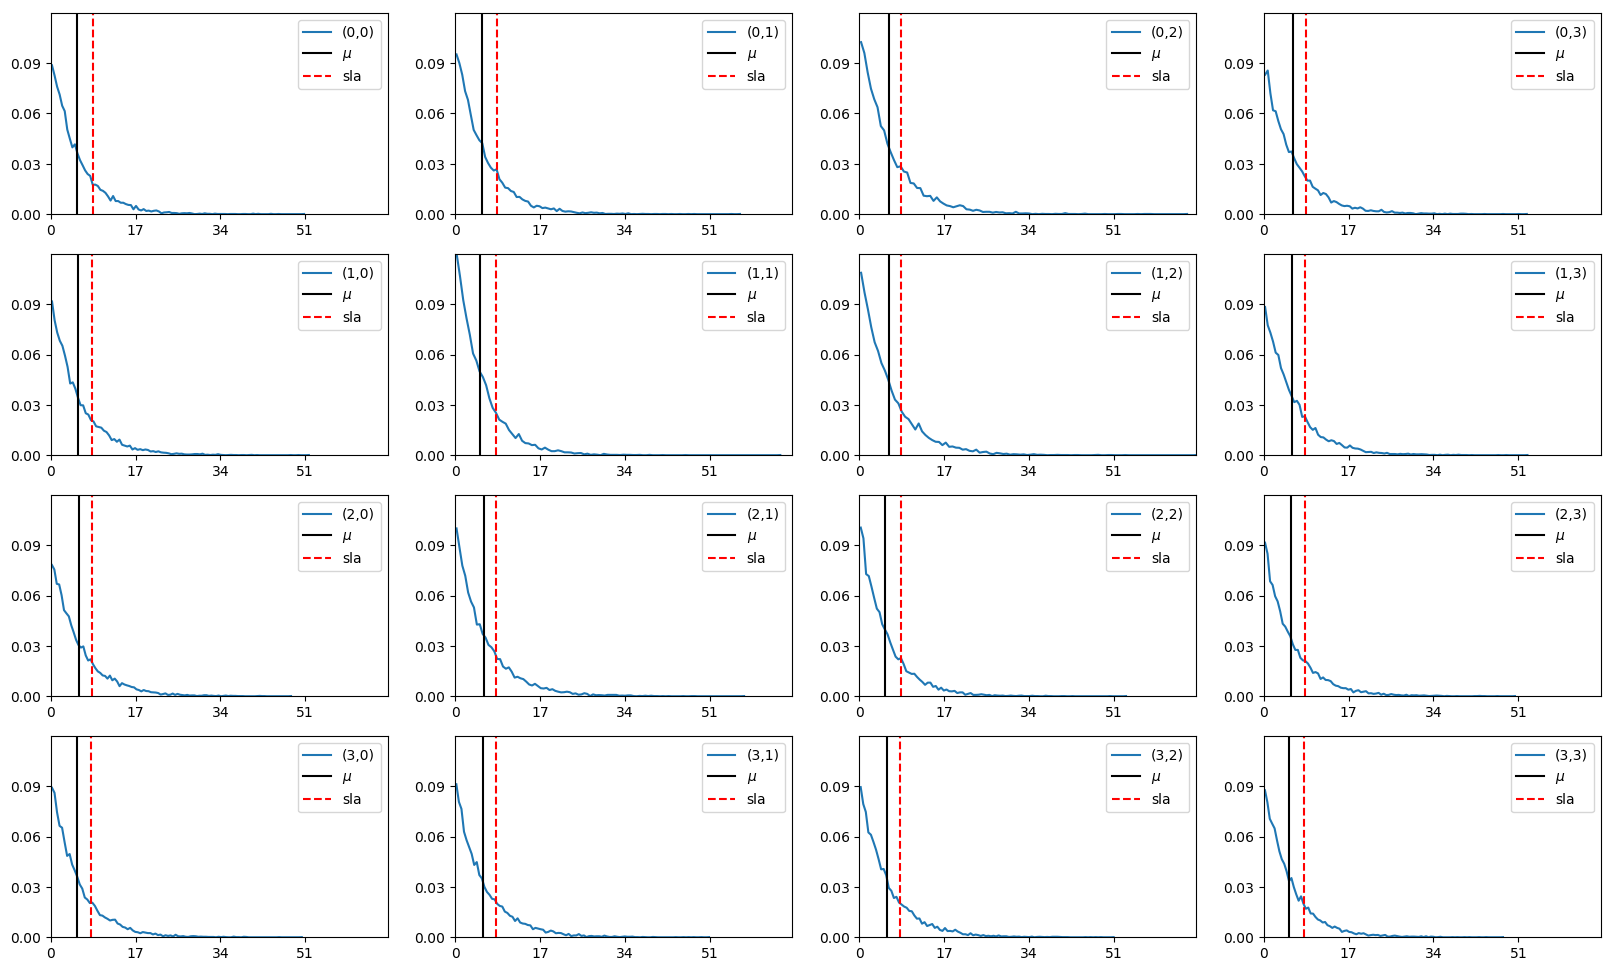

In [15]:
data_q = draw_delays(graph["mu_Q"], graph["var_Q"], P=10000, distr=distr["Q"])
plot_graph(data_q, sla=sla["mu_Q"])

## Service time distribution


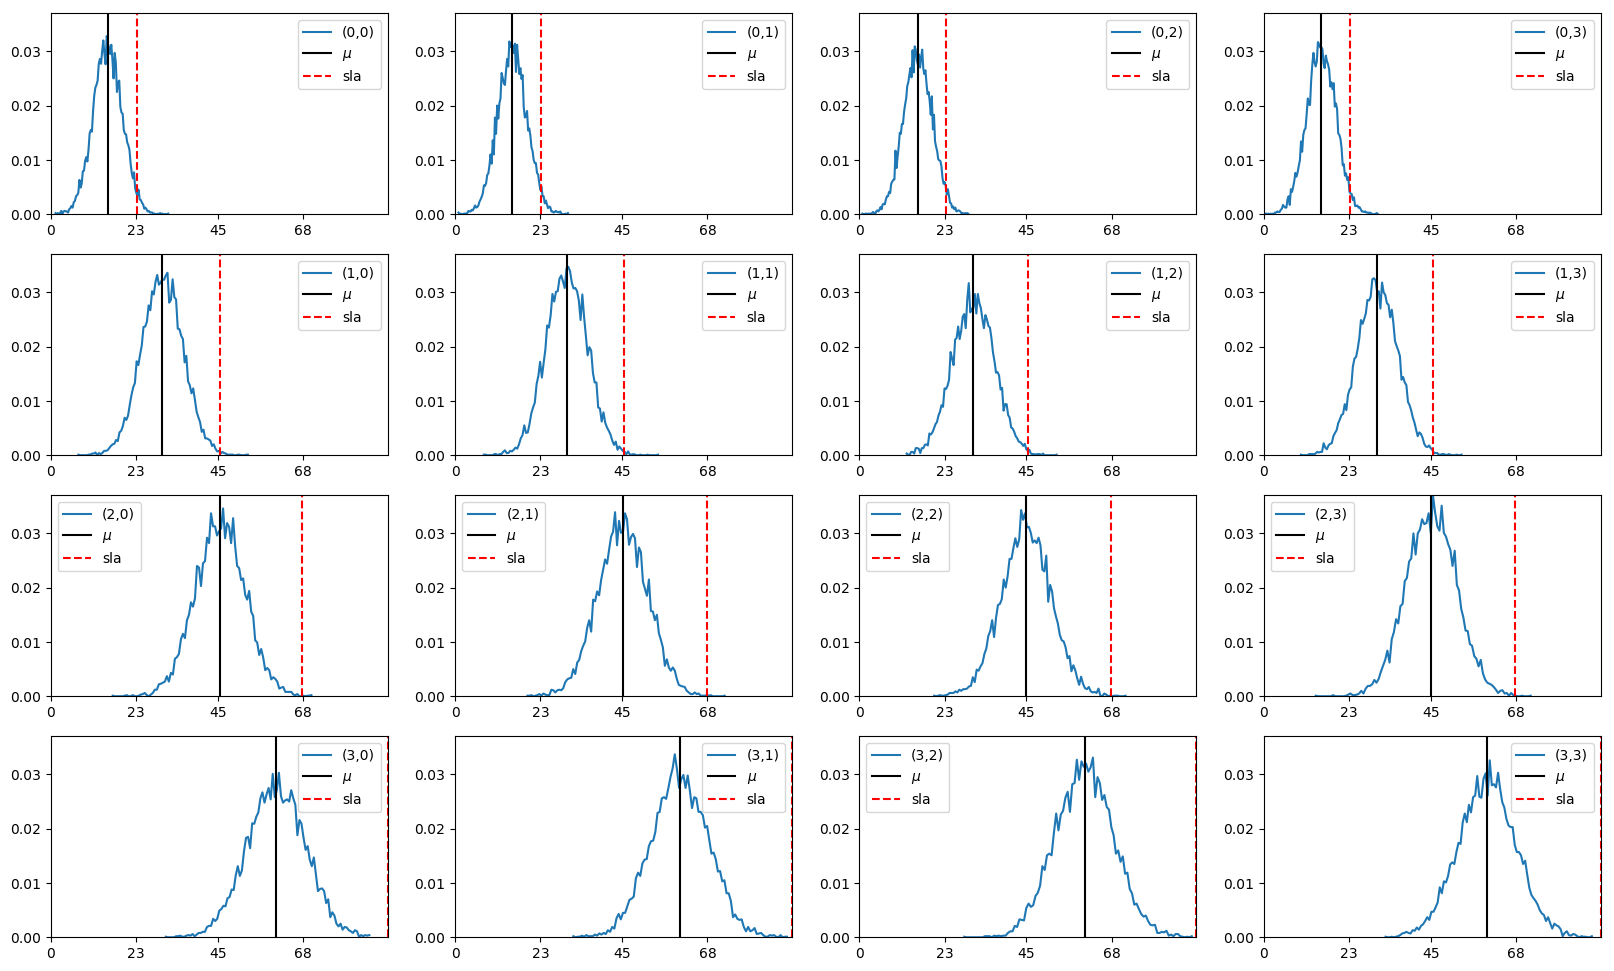

In [16]:
data_s = draw_delays(graph["mu_S"], graph["var_S"], P=10000, distr=distr["S"])
plot_graph(data_s, sla=sla["mu_S"])

## Delays distribution (Delay = Queue + Service)


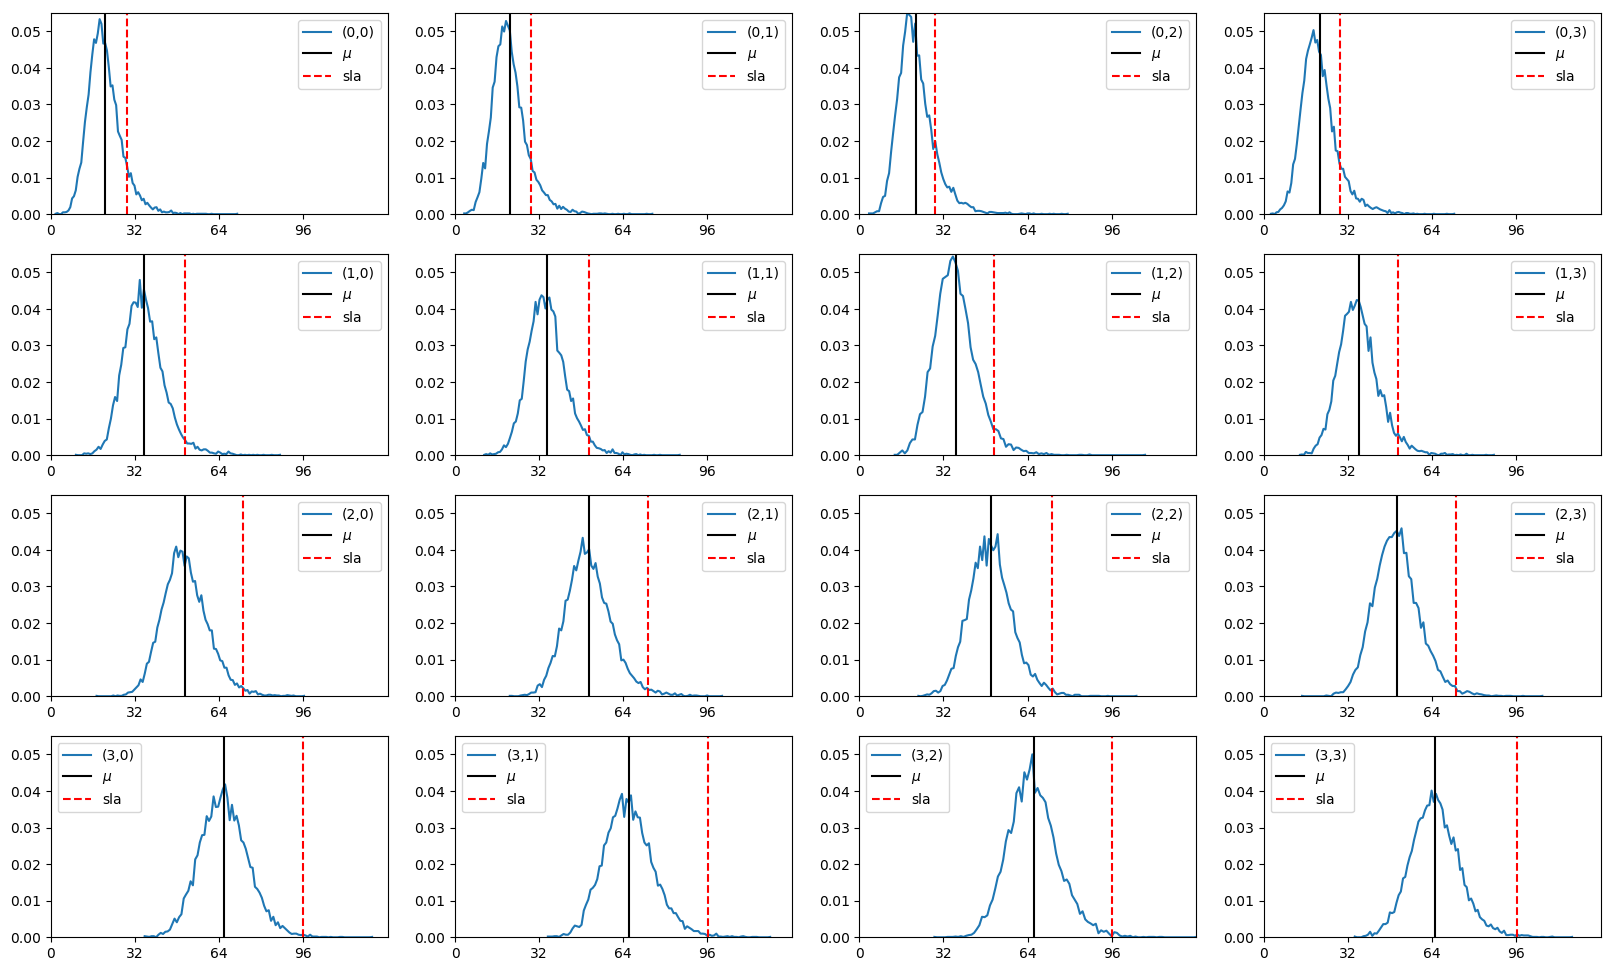

In [17]:
plot_graph(data_q+data_s, sla=sla["mu_S"])

Random walk during 700 timesteps, altering sig_S by a random number

In [18]:
steps = 701
win_size = 3
diff_var_approx = np.zeros((steps, L, N)) 
var = np.zeros((steps, L, N))

percentiles = np.zeros((steps, 5))

orig = graph["var_S"].copy()
print(orig)
P=1000
for s in range(steps):
    var[s] = graph["var_S"]
    travel_times = []
    for layer in range(L):
        _, diffs, trav_times = approximate_diffs(layer, graph, distr, P)
        travel_times += trav_times  
        minimum = np.argsort(diffs.sum(axis=1))[0]
        diff_var_approx[s][layer] = -diffs[minimum]
        
        for node in range(N):
            roll = pd.Series(diff_var_approx[:s+1,layer,node]).rolling(win_size, min_periods=1).mean()
            if roll.values[-1] > sla["var_S"][layer]:
                print(roll.values[-1], "vs", sla["var_S"][layer])
                print(s, "/", steps, "reset", layer, node, ":", graph["var_S"][layer][node] , "to", orig[layer][node])
                graph["var_S"][layer][node] = orig[layer][node]
    
            # random walk
            graph["var_S"][layer][node] += 2*(np.random.rand()-0.4)
            graph["var_S"][layer][node] = max(graph["var_S"][layer][node], orig[layer][node])
            len_tt = len(travel_times)
    
    perc_idx = [x for x in range(int(len_tt/5), len_tt+1, int(len_tt/5))]
    perc_idx[-1] = perc_idx[-1]-1
    percentiles[s] = np.array(sorted(travel_times))[perc_idx]
    
graph["var_S"], sla

[[ 15.22605009  15.58238505  15.32035258  15.54628284]
 [ 30.72708326  30.96488676  30.7830583   30.45011963]
 [ 45.44522759  45.99950764  45.03530487  45.51498664]
 [ 60.1546019   60.64145201  60.37371142  60.74381902]]
20.3348229777 vs 15.418767639
4 / 701 reset 0 2 : 18.4278097615 to 15.3203525811
16.7587264891 vs 15.418767639
11 / 701 reset 0 2 : 16.2232021566 to 15.3203525811
17.3764223871 vs 15.418767639
12 / 701 reset 0 2 : 16.0320853527 to 15.3203525811
16.268201287 vs 15.418767639
12 / 701 reset 0 3 : 17.0924541643 to 15.546282843
17.304942334 vs 15.418767639
15 / 701 reset 0 2 : 15.4453303753 to 15.3203525811
19.7040267457 vs 15.418767639
16 / 701 reset 0 2 : 16.2542585094 to 15.3203525811
19.7323561074 vs 15.418767639
17 / 701 reset 0 2 : 15.3203525811 to 15.3203525811
16.0971039118 vs 15.418767639
28 / 701 reset 0 2 : 17.0912325475 to 15.3203525811
21.5409080916 vs 15.418767639
29 / 701 reset 0 2 : 15.8433028235 to 15.3203525811
15.5157194702 vs 15.418767639
31 / 701 reset 

31.0042150979 vs 30.7312869898
241 / 701 reset 1 2 : 37.4525966132 to 30.7830583022
17.8043994846 vs 15.418767639
246 / 701 reset 0 2 : 16.6240290555 to 15.3203525811
20.0277583808 vs 15.418767639
247 / 701 reset 0 2 : 15.9768812115 to 15.3203525811
15.9472608564 vs 15.418767639
249 / 701 reset 0 0 : 20.5272835112 to 15.2260500867
21.9044648034 vs 15.418767639
257 / 701 reset 0 3 : 18.2164553556 to 15.546282843
17.0617684668 vs 15.418767639
258 / 701 reset 0 3 : 15.546282843 to 15.546282843
16.9685845714 vs 15.418767639
259 / 701 reset 0 3 : 15.9215340887 to 15.546282843
17.32173158 vs 15.418767639
260 / 701 reset 0 1 : 21.6042832695 to 15.5823850453
19.1987757795 vs 15.418767639
260 / 701 reset 0 2 : 17.2270272349 to 15.3203525811
18.0108170387 vs 15.418767639
261 / 701 reset 0 1 : 16.4103157385 to 15.5823850453
15.9332634576 vs 15.418767639
262 / 701 reset 0 1 : 16.7480338481 to 15.5823850453
16.0960100354 vs 15.418767639
266 / 701 reset 0 2 : 16.3285843597 to 15.3203525811
15.807172

16.0699384348 vs 15.418767639
433 / 701 reset 0 2 : 17.1300696102 to 15.3203525811
17.9887798901 vs 15.418767639
434 / 701 reset 0 3 : 15.8789712622 to 15.546282843
18.9264232236 vs 15.418767639
441 / 701 reset 0 0 : 22.9667325352 to 15.2260500867
20.3883607372 vs 15.418767639
442 / 701 reset 0 0 : 15.5207449074 to 15.2260500867
15.7043975078 vs 15.418767639
443 / 701 reset 0 0 : 15.2260500867 to 15.2260500867
17.3223985274 vs 15.418767639
443 / 701 reset 0 2 : 17.7344911695 to 15.3203525811
18.1276499255 vs 15.418767639
444 / 701 reset 0 2 : 16.0179095065 to 15.3203525811
16.5817355292 vs 15.418767639
446 / 701 reset 0 1 : 24.6540769719 to 15.5823850453
17.4387342554 vs 15.418767639
448 / 701 reset 0 3 : 19.2851801208 to 15.546282843
25.0700032226 vs 15.418767639
449 / 701 reset 0 3 : 15.7703281508 to 15.546282843
19.3018856906 vs 15.418767639
450 / 701 reset 0 2 : 15.8015533453 to 15.3203525811
18.2659161892 vs 15.418767639
450 / 701 reset 0 3 : 16.2749577281 to 15.546282843
50.69846

16.8506144411 vs 15.418767639
598 / 701 reset 0 1 : 22.0231358735 to 15.5823850453
18.2564809323 vs 15.418767639
599 / 701 reset 0 1 : 15.5823850453 to 15.5823850453
16.760788994 vs 15.418767639
606 / 701 reset 0 3 : 22.2751034715 to 15.546282843
15.9453144148 vs 15.418767639
607 / 701 reset 0 2 : 20.1697293108 to 15.3203525811
18.2796769399 vs 15.418767639
608 / 701 reset 0 2 : 15.4278388084 to 15.3203525811
21.1214931211 vs 15.418767639
615 / 701 reset 0 0 : 24.6536947592 to 15.2260500867
15.6533268364 vs 15.418767639
616 / 701 reset 0 0 : 16.2186840104 to 15.2260500867
21.1269950533 vs 15.418767639
616 / 701 reset 0 2 : 17.8456874593 to 15.3203525811
16.8082768275 vs 15.418767639
617 / 701 reset 0 1 : 20.6227556212 to 15.5823850453
17.3917449938 vs 15.418767639
617 / 701 reset 0 2 : 15.3203525811 to 15.3203525811
20.0406122167 vs 15.418767639
618 / 701 reset 0 1 : 15.5823850453 to 15.5823850453
15.67933353 vs 15.418767639
618 / 701 reset 0 2 : 15.3203525811 to 15.3203525811
15.61800

(array([[  17.82462733,   17.16299108,   15.81328347,   16.14097817],
        [  33.32457083,   36.57951099,   32.66606009,   39.70339653],
        [  88.85132487,  100.96908615,   96.84551912,   94.78436816],
        [ 100.81635855,  106.92117471,   93.89938855,   95.30148948]]),
 {'mu_Q': array([ 2.79141306,  2.74544772,  2.7536534 ,  2.72706335]),
  'mu_S': array([  7.75732803,  15.19405442,  22.61211506,  30.25284272]),
  'var_Q': array([ 0.,  0.,  0.,  0.]),
  'var_S': array([ 15.41876764,  30.73128699,  45.49875668,  60.47839609])})

Plot the results

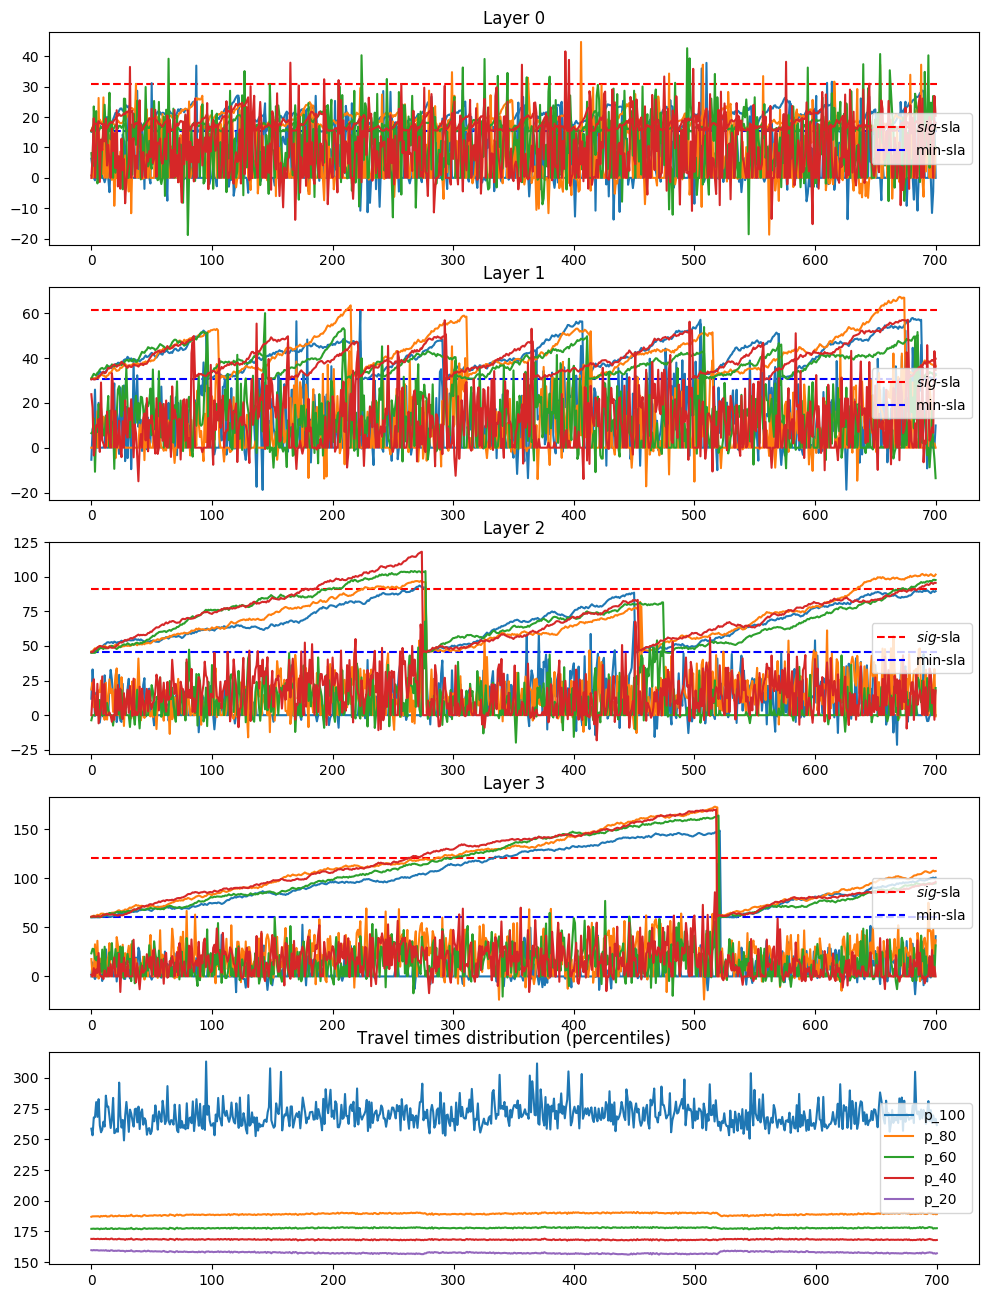

In [19]:
plt.rcParams.update(plt.rcParamsDefault)    
f, ax = plt.subplots(L+1, figsize=(12,16))

colors = ['C0', 'C1', 'C2', 'C3', 'C4', 'C5', 'C6', 'C7', 'C8', 'C9']

for layer in range(L):

    t = np.mean(orig[layer]) + sla["var_S"][layer] 
    ax[layer].plot([0, len(diff_var_approx)], [t, t], "r--", label="$sig$-sla")
    ax[layer].plot([0, len(diff_var_approx)], [sla["var_S"][layer], sla["var_S"][layer]], "b--", label="min-sla")

    for n in range(N):
        ax[layer].plot(diff_var_approx[:,layer,n], color=colors[n])
        ax[layer].plot(var[:,layer, n], color=colors[n])
    ax[layer].legend(loc="center right")
    ax[layer].set_title("Layer " + str(layer))

    
for i in range(5,0,-1):
    label = "p_"+str((i)*20)
    ax[L].plot(percentiles[:,i-1], label=label)
    ax[L].legend(loc="center right")
    ax[L].set_title("Travel times distribution (percentiles)")


In [ ]:
plot_graph(graph["mu_S"], graph["sig_S"], P=P, distr=distr["S"], sla=sla["mu_S"])

Monitor the layer for 700 timesteps, and after timestep 100, gradually increase mu_S for node 0, and at time 350 gradually increase for mu_S for node 1

In [ ]:
steps=701
mu_approx, mu_truth = np.zeros((steps, N)), np.zeros((steps, N)) 
var_approx, var_truth = np.zeros((steps, N)), np.zeros((steps, N)) 

orig = graph["sig_S"].copy()
print(orig)


for o in range(701):
    mu_a, var_a, mu_t, var_t = simulate_layer(graph, layer=0, P=P, distr=distr)
    mu_approx[o] = mu_a
    var_approx[o] = var_a
    mu_truth[o] = mu_t
    var_truth[o] = var_t

    for node in range(N):
        if o > 100:
            graph["sig_S"][0][0] += np.random.rand()*0.01
        if o > 350:
            graph["sig_S"][0][1] += np.random.rand()*0.01
    
        roll = pd.Series(var_approx[:o+1,node]).rolling(1, min_periods=1).mean()
        if roll.values[-1] > sla["mu_S"][0]:
            print(roll.values[-1], var_truth[0,node])
            print("reset", graph["sig_S"][0][node] , "to", orig[0][node])
            graph["sig_S"][0][node] = orig[0][node]
    
graph["mu_S"], graph["sig_S"]


Plot the **mu** monitoring results (***we see nothing conclusive***)

In [ ]:
plt.rc('text', usetex=True)
plt.rc('font', family='serif', size=32)
fig = plt.figure(figsize=(15, 20))
ax = fig.add_subplot(2,1,1)
ax.set_ylabel(r"deviation",fontsize=32)
ax.set_xlabel(r"time steps",fontsize=32)

colors = ['C0', 'C1', 'C2', 'C3', 'C4', 'C5', 'C6', 'C7', 'C8', 'C9']

plt.plot([0, len(mu_truth)], [sla["mu_S"][0], sla["mu_S"][0]], "r--", label="sla")

for n in range(N):
    x = [y[n] for y in mu_truth ]
    y = [z[n] for z in mu_approx ]
    plt.plot(x, label="$\widehat{\delta'}$", color=colors[n])
    plt.plot(y, label="$\delta'$", marker='o', markevery=25, markersize=15, linewidth=0)

plt.grid(linewidth=2)

Plot the **sig** monitoring results (***we see some node having much greater variance***)

In [ ]:
plt.rc('text', usetex=True)
plt.rc('font', family='serif', size=32)
fig = plt.figure(figsize=(15, 20))
ax = fig.add_subplot(2,1,1)
ax.set_ylabel(r"deviation",fontsize=32)
ax.set_xlabel(r"time steps",fontsize=32)

colors = ['C0', 'C1', 'C2', 'C3', 'C4', 'C5', 'C6', 'C7', 'C8', 'C9']

for n in range(N):
    x = [y[n] for y in var_truth ]
    y = [z[n] for z in var_approx ]
    plt.plot(x, label="$\widehat{\delta'}$", color=colors[n])
    plt.plot(y, label="$\delta'$", marker='o', markevery=25, markersize=15, linewidth=0)

plt.grid(linewidth=2)

### Performance Monitoring and Random Walk : everything is moving in EVERY LAYER - not only layer 0 ###

Generate a graph with random distribution means

In [ ]:
N = 5
L = 5
graph = init_graph(L, N)
graph["mu_Q"][1:]*=50
graph["mu_Q"][1:]+=50
graph["mu_Q"][0] +=5

graph["mu_S"][1:]*=50
graph["mu_S"][1:]+=50
graph["mu_S"][0] +=5

graph

Monitor the layer for 502 timesteps, and after timestep 100, turn on the random walk for every node of the graph

In [ ]:

P=250
approx, truth = [], []
distr ={"Q":"exp", "S":"exp"}
for o in range(502):
    for layer in range(L):
        for node in range(N):
            if o > 100:
                graph["S"][layer][node] += np.random.rand()-0.5
                graph["S"][layer][node] = abs(graph["S"][layer][node])
    a, t = simulate_layer(graph, layer=0, P=P, distr=distr)
    approx.append(a)
    truth.append(t)
graph

Plot the results

In [ ]:
plt.rc('text', usetex=True)
plt.rc('font', family='serif', size=32)
fig = plt.figure(figsize=(15, 20))
ax = fig.add_subplot(2,1,1)
ax.set_ylabel(r"deviation",fontsize=32)
ax.set_xlabel(r"time steps",fontsize=32)

colors = ['C0', 'C1', 'C2', 'C3', 'C4', 'C5', 'C6', 'C7', 'C8', 'C9']

for n in range(N):
    x = [y[n] for y in truth ]
    y = [z[n] for z in approx ]
    plt.plot(x, label="$\widehat{\delta'}$", color=colors[n])
    plt.plot(y, label="$\delta'$", marker='o', markevery=25, markersize=15, linewidth=0)

plt.grid(linewidth=2)

### Sensitivity, Error and Sample Size ###

Compute and return the absolute difference bewteen true and approximated delays

In [ ]:
def abs_diff_samples(graph, P, distr):
    L = graph["Q"].shape[0]
    diff = np.array([])
    for layer in range(L):
        a, t = simulate_layer(graph, layer=layer, P=P, distr=distr)
        diff = np.concatenate((diff, np.abs(a-t)))
    return diff

In [ ]:
N = 10
L = 10
distr = {"Q":"exp", "S":"gaussian"}
diffs = {}
graph = init_graph(L,N)
graph["Q"] *= 100
graph["S"] *= 100

for p in [100, 250, 1000, 5000, 50000]:
    diffs[p] = abs_diff_samples(graph, p, distr)

In [ ]:
plt.rc('text', usetex=True)
plt.rc('font', family='serif', size=32)
fig = plt.figure(figsize=(15, 20))
ax = fig.add_subplot(2,1,1)
ax.set_ylabel(r"$|\delta' - \widehat{\delta'}|$",fontsize=32)
ax.set_xlabel(r"graph nodes",fontsize=32)
#ax.set_title(r"normal distribution",fontsize=32)


for d in sorted(diffs):
    label = "p=" + str(d)
    if d > 500:
        label = "p=" +str(int(d/1000))+"k"        
    plt.plot(sorted(diffs[d], reverse=True), label=label, linewidth=4)
plt.legend(loc="best")
plt.grid(linewidth=2)

### Work in progress : Layer scale approximation ###

In [ ]:
N = 11
L = 21
sigma=0.5
graph = init_graph(L,N)

betas = sorted(np.random.rand(L))

for i in range(L):
    graph[i] += 20*betas[i]        
    graph[i] *= np.ones(N) + 0.05*np.random.rand(N)

    

graph

In [ ]:
times=250
A  = np.zeros((L, N, times))
T  = np.zeros((L, N, times))

for i in range(times):
    print(i)
    for l in range(L):
        a, t  = simulate_layer(graph, layer=l, P=50, distr="normal")
        A[l,:,i] = a
        T[l,:,i] = t

In [ ]:
#data = np.abs(A).mean(axis=(1,2))
#data_t = np.abs(T).mean(axis=(1,2))

data = np.abs(A).mean(axis=(2)).sum(axis=1)
#data_t = np.abs(T).median(axis=(1,2))

In [ ]:
graph[8]

In [ ]:
plt.rc('text', usetex=True)
plt.rc('font', family='serif', size=32)
fig = plt.figure(figsize=(15, 20))
ax = fig.add_subplot(2,1,1)
ax.set_ylabel(r"$\overline{|\delta'_{l,i}|}$",fontsize=32, rotation=0)
ax.yaxis.set_label_coords(-0.075,0.5)

ax.set_xlabel(r"layer index ($l$)",fontsize=32)

plt.plot(range(1,L+1), data,  label=r"$\overline{\beta_{l}} \approx l,  \forall l$")
plt.plot(range(1,L+1), 2*np.sqrt(graph*sigma).mean(axis=1), label="beta")
#plt.plot(range(1,L+1), graph.mean(axis=1)*(sigma), label="beta")

#plt.plot(range(1,L+1), np.power(graph.std(axis=1),20), label="beta")

#plt.plot(range(1,L+1), graph.mean(axis=1)/data, label="beta")


plt.grid(linewidth=2)
plt.legend(loc="best")
